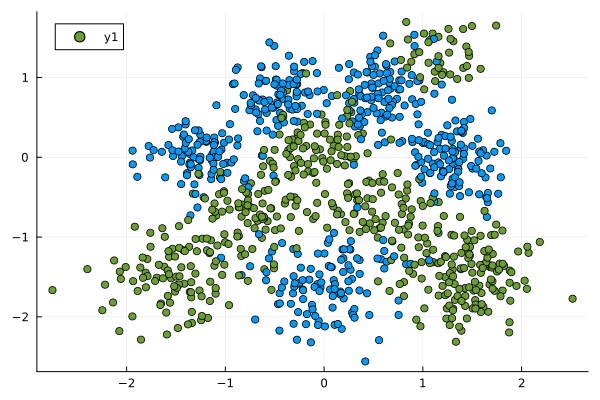

In [54]:
using DataFrames, CSV, DelimitedFiles
using Plots
using Zygote
using ForwardDiff

X = [ones(1000, 1) readdlm("X.txt", ' ', Float64)] 
y = readdlm("y.txt", ' ', Int64) 

scatter(X[:, 2], X[:, 3], markercolor=y)

## Regression

Model using:

$$ y = w^T X + b + \epsilon_n$$

where:

$$ \epsilon_n \sim \mathcal{N}(0, \sigma^2) $$

by adding a third dimension to X, as done above, we can use:

$$ y = w^T \tilde{X} + \epsilon_n$$

Ultimately we have:

$$ p(y_n | \tilde{\mathbf{x}}_n, \mathbf{\theta}) = \mathcal{N}(y_n | \mathbf{w}^t \tilde{\mathbf{x}}_n, \sigma^2) $$



## Logistic Regression

$$\begin{align*}
 p(y_n | \tilde{\mathbf{x}}_n, \mathbf{\theta}) &= y_n \sigma (\mathbf{w}^T \tilde{\mathbf{x}}_n) + (1 - y_n) (1 - \sigma (\mathbf{w}^T \tilde{\mathbf{x}}_n))\\
&= y_n \sigma (\mathbf{w}^T \tilde{\mathbf{x}}_n) + (1 - y_n)  \sigma (-\mathbf{w}^T \tilde{\mathbf{x}}_n)\\
\end{align*}$$


In [55]:
logistic(X) = 1 / (1 + exp(-clamp.(X, -100, 100)))

likelihood(X, y, w) = y .* logistic.(X * w) .+ (1 .- y) .* logistic.(-X * w)

log_loss(X, y, w) = sum(log.(likelihood(X, y, w)))

log_loss (generic function with 1 method)

-954.5333085997798


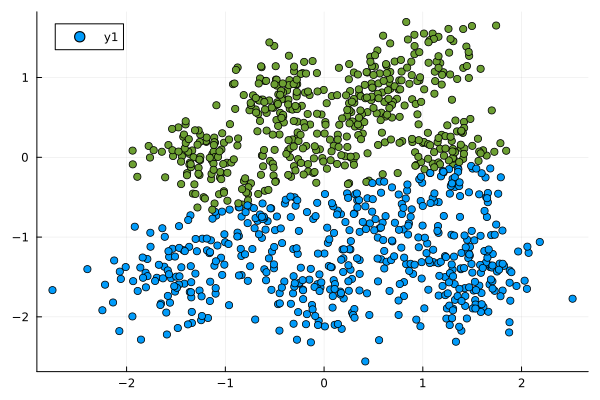

In [56]:
w = randn(3, 1)
predictions = logistic.(X * w)
binary_pred = predictions .|> (x -> x < 0.5 ? 0 : 1)

println(log_loss(X, y, w))
scatter(X[:, 2], X[:, 3], markercolor=binary_pred)


In [57]:
# Gradient ascent
function train(Input, labels; lr=0.01, epochs=100_000)
    n_features = size(Input, 2)
    params = randn(n_features, 1) .* 0.01 # Initialize weights
    println("Initial log likelihood = $(log_loss(Input, labels, params))")
    
    for i in 1:epochs
        lr = lr * 0.9999  # Decrease learning rate
        # Compute gradient using Zygote
        grad = Zygote.gradient(params -> log_loss(Input, labels, params), params)[1]

        # Update weights (ascent because we're maximizing)
        params .+= lr * grad

        # Print progress every 100 epochs
        if i % 10_000 == 0
            loss = log_loss(Input, labels, params)
            println("Epoch $i: log likelihood = $loss")
            
            
        end
    end
    println("Training complete.")
    println("Final log likelihood = $(log_loss(Input, labels, params))")
    return params
end

train (generic function with 1 method)

Initial log likelihood = -692.0893606324958
Epoch 10000: log likelihood = -623.4619710586629
Epoch 20000: log likelihood = -623.4619710586629
Epoch 30000: log likelihood = -623.4619710586629
Epoch 40000: log likelihood = -623.4619710586629
Epoch 50000: log likelihood = -623.4619710586629
Epoch 60000: log likelihood = -623.4619710586629
Epoch 70000: log likelihood = -623.4619710586629
Epoch 80000: log likelihood = -623.4619710586629
Epoch 90000: log likelihood = -623.4619710586629
Epoch 100000: log likelihood = -623.4619710586629
Training complete.
Final log likelihood = -623.4619710586629


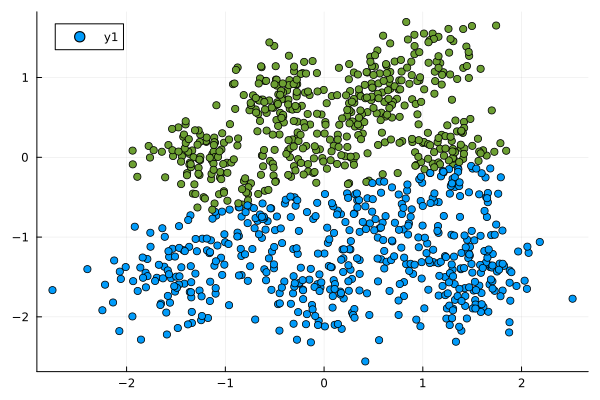

In [58]:
w_opt = train(X, y)
predictions = logistic.(X * w)
binary_pred = predictions .|> (x -> x < 0.5 ? 0 : 1)

scatter(X[:, 2], X[:, 3], markercolor=binary_pred)

In [59]:
X_nl = [X X[:, 2].^2 X[:, 3].^2 X[:, 2].*X[:, 3] X[:, 2].^3 X[:, 3].^3 X[:, 2].^2 .*X[:, 3] X[:, 2].*X[:, 3].^2]

1000×10 Matrix{Float64}:
 1.0  -0.622946  -0.578796   0.388062   …  -0.224609    -0.20869
 1.0   1.09961    1.55007    1.20915        1.87426      2.64205
 1.0   0.754785  -1.97616    0.569701      -1.12582      2.94759
 1.0  -1.13635   -0.0386258  1.29129       -0.049877    -0.00169538
 1.0  -0.122666  -1.85083    0.015047      -0.0278494   -0.4202
 1.0  -0.630019  -1.00966    0.396923   …  -0.400756    -0.642244
 1.0   1.41677    0.443055   2.00724        0.889319     0.27811
 1.0   1.37633   -0.746924   1.89429       -1.41489      0.767849
 1.0  -1.35971   -1.68841    1.84882       -3.12156     -3.87616
 1.0   1.64659    0.0216457  2.71126        0.058687     0.000771486
 ⋮                                      ⋱               
 1.0   1.65114   -0.512764   2.72627       -1.39794      0.43413
 1.0   1.30492   -1.91796    1.70282       -3.26594      4.80026
 1.0   0.745378  -0.197957   0.555589      -0.109982     0.029209
 1.0   1.21443    0.0200895  1.47484        0.0296288    0.00049

Initial log likelihood = -692.3339709263713
Epoch 10000: log likelihood = -383.84744125441773
Epoch 20000: log likelihood = -341.18960627636733
Epoch 30000: log likelihood = -341.1896062763674
Epoch 40000: log likelihood = -341.1896062763674
Epoch 50000: log likelihood = -341.1896062763674
Epoch 60000: log likelihood = -341.1896062763674
Epoch 70000: log likelihood = -341.1896062763674
Epoch 80000: log likelihood = -341.1896062763674
Epoch 90000: log likelihood = -341.1896062763674
Epoch 100000: log likelihood = -341.1896062763674
Training complete.
Final log likelihood = -341.1896062763674


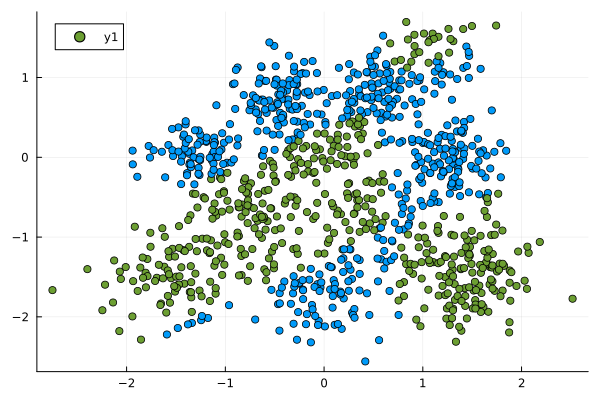

In [60]:
w_opt_nl = train(X_nl, y)
predictions = logistic.(X_nl * w_opt_nl)
binary_pred = predictions .|> (x -> x < 0.5 ? 0 : 1)

scatter(X[:, 2], X[:, 3], markercolor=binary_pred)